In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nbaiot-dataset/7.gafgyt.combo.csv
/kaggle/input/nbaiot-dataset/9.gafgyt.combo.csv
/kaggle/input/nbaiot-dataset/5.gafgyt.combo.csv
/kaggle/input/nbaiot-dataset/1.mirai.udp.csv
/kaggle/input/nbaiot-dataset/4.gafgyt.udp.csv
/kaggle/input/nbaiot-dataset/6.gafgyt.udp.csv
/kaggle/input/nbaiot-dataset/6.gafgyt.junk.csv
/kaggle/input/nbaiot-dataset/data_summary.csv
/kaggle/input/nbaiot-dataset/5.gafgyt.udp.csv
/kaggle/input/nbaiot-dataset/9.gafgyt.junk.csv
/kaggle/input/nbaiot-dataset/9.mirai.scan.csv
/kaggle/input/nbaiot-dataset/1.benign.csv
/kaggle/input/nbaiot-dataset/2.mirai.udpplain.csv
/kaggle/input/nbaiot-dataset/3.gafgyt.combo.csv
/kaggle/input/nbaiot-dataset/4.gafgyt.combo.csv
/kaggle/input/nbaiot-dataset/6.mirai.scan.csv
/kaggle/input/nbaiot-dataset/5.mirai.udp.csv
/kaggle/input/nbaiot-dataset/3.benign.csv
/kaggle/input/nbaiot-dataset/3.gafgyt.junk.csv
/kaggle/input/nbaiot-dataset/7.gafgyt.scan.csv
/kaggle/input/nbaiot-dataset/features.csv
/kaggle/input/nbaiot-dataset/6

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")


## Load and Label Data

In [3]:
# Load CSVs
df_benign = pd.read_csv('/kaggle/input/nbaiot-dataset/4.benign.csv')
df_udp = pd.read_csv('/kaggle/input/nbaiot-dataset/4.gafgyt.udp.csv')
df_junk = pd.read_csv('/kaggle/input/nbaiot-dataset/5.gafgyt.junk.csv')

# Label them
df_benign['Attack_Class'] = 'benign'
df_udp['Attack_Class'] = 'gafgyt_udp'
df_junk['Attack_Class'] = 'gafgyt_junk'


## Combine, Remove Duplicates, and Sample

In [4]:
# Combine data
df = pd.concat([df_benign, df_udp, df_junk], ignore_index=True)

# Drop duplicates
df.drop_duplicates(inplace=True)

# Filter specific classes (for this example)
selected_classes = ['benign', 'gafgyt_udp', 'gafgyt_junk']
df_filtered = df[df['Attack_Class'].isin(selected_classes)]

# Balance sampling: take 20,000 samples from each class
df_sampled = df_filtered.groupby('Attack_Class').apply(lambda x: x.sample(20000, replace=True)).reset_index(drop=True)


## Feature Selection 

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


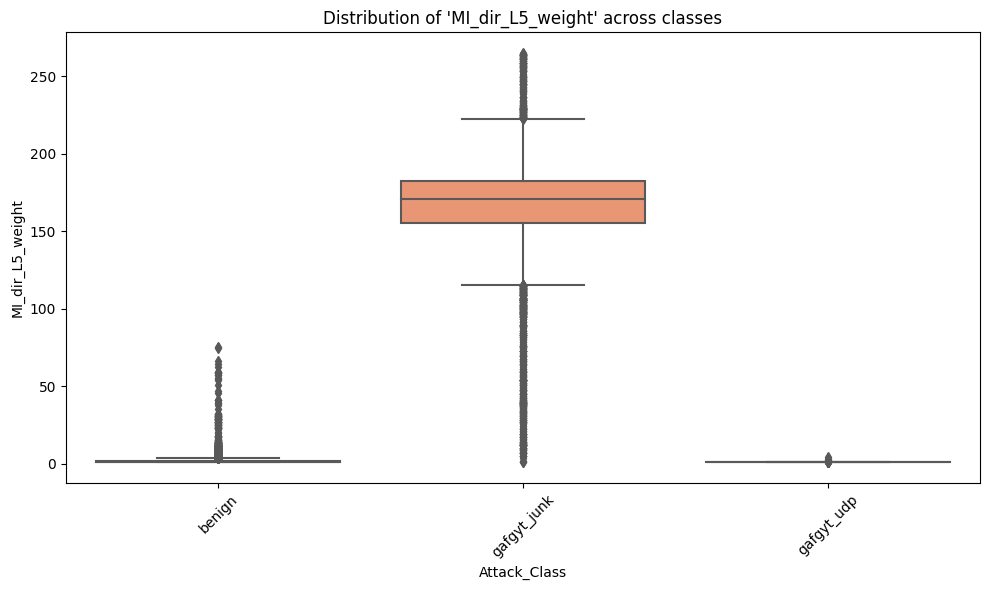

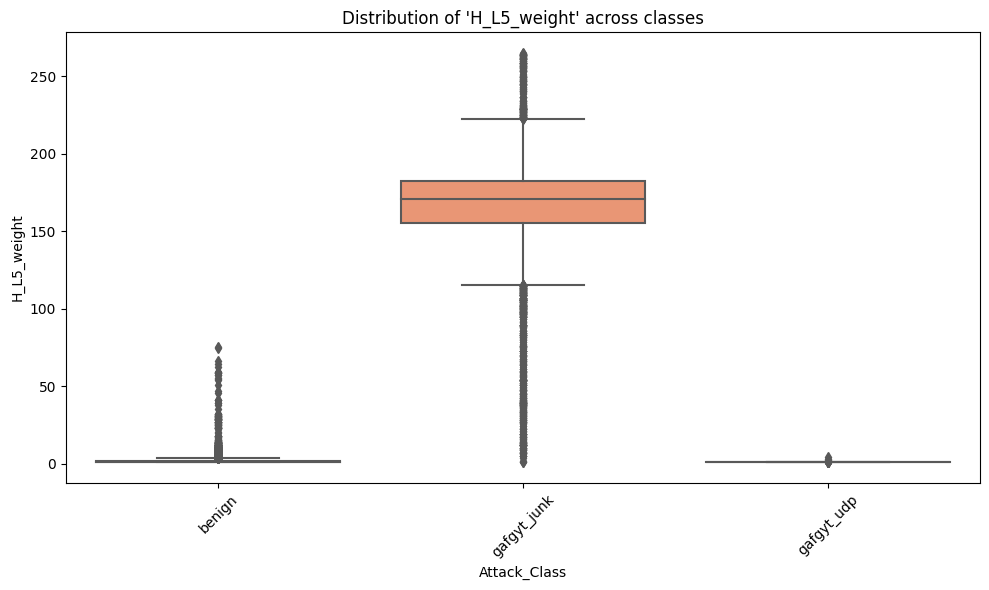

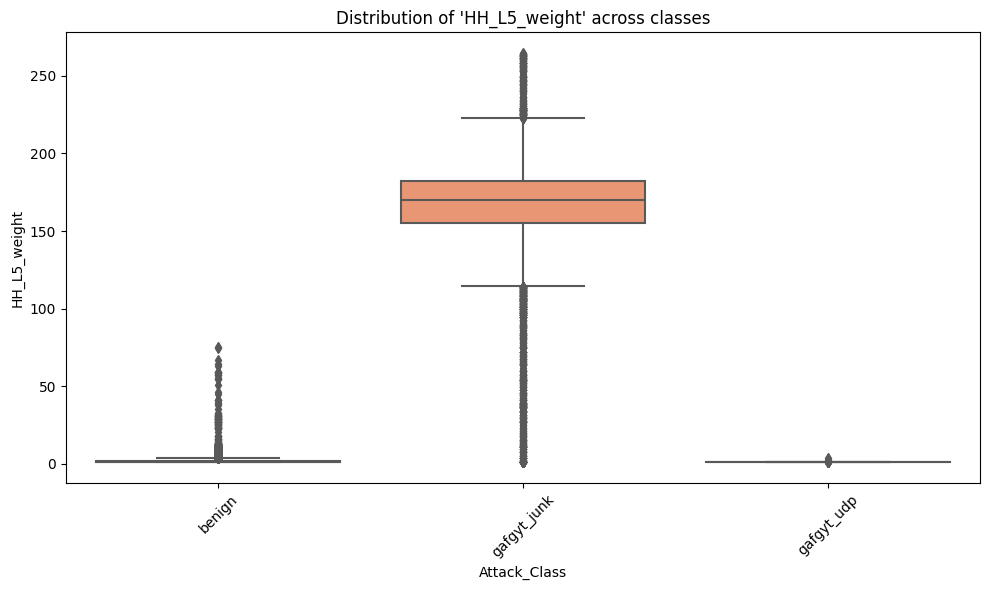

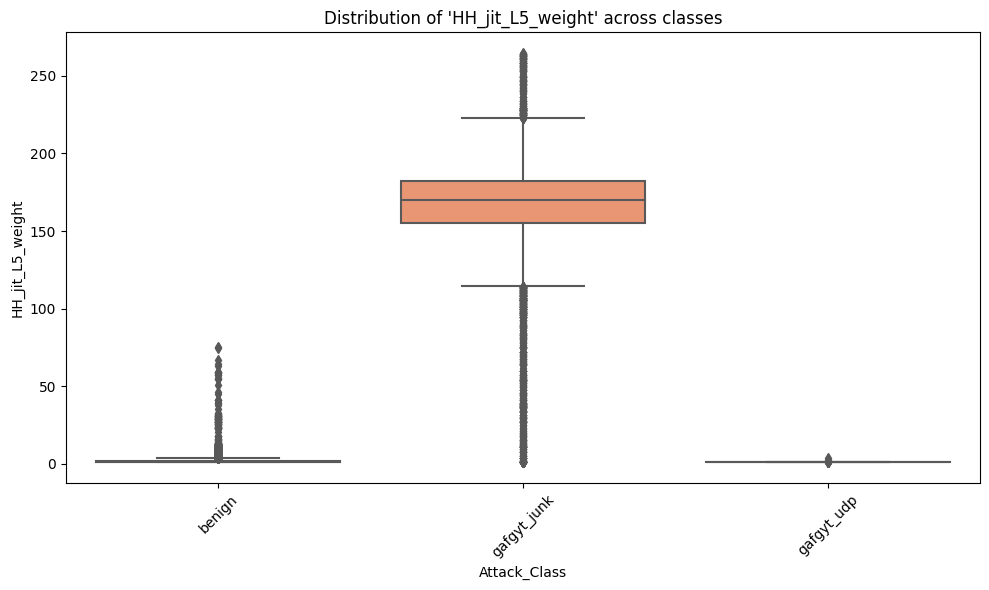

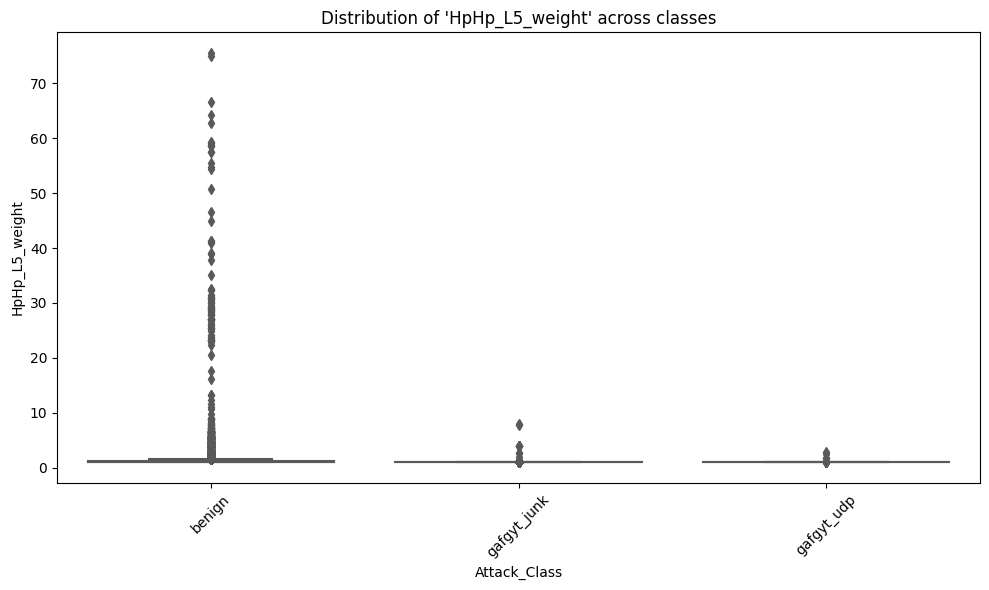

In [16]:
# Remove statistical features like mean, variance
features_to_exclude = ['mean', 'variance', 'std', 'radius', 'magnitude', 'pcc']
numeric_columns = df_sampled.select_dtypes(include=['float64', 'int64']).columns
filtered_features = [col for col in numeric_columns if not any(ex in col for ex in features_to_exclude)]

# Selected important features
selected_features = ['MI_dir_L5_weight', 'H_L5_weight', 'HH_L5_weight', 'HH_jit_L5_weight', 'HpHp_L5_weight']

# Box plot for each feature grouped by Attack Class
for feature in selected_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_sampled, x='Attack_Class', y=feature, palette='Set2')
    plt.title(f"Distribution of '{feature}' across classes")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



## Encode Labels & Split Data

In [7]:
# Encode labels
le = LabelEncoder()
df_sampled['Attack_Class_Encoded'] = le.fit_transform(df_sampled['Attack_Class'])

# Train/test split
X = df_sampled[selected_features]
y = df_sampled['Attack_Class_Encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Train & Evaluate Random Forest

Random Forest Report
              precision    recall  f1-score   support

      benign       1.00      0.85      0.92      6014
 gafgyt_junk       1.00      1.00      1.00      5987
  gafgyt_udp       0.87      1.00      0.93      5999

    accuracy                           0.95     18000
   macro avg       0.96      0.95      0.95     18000
weighted avg       0.96      0.95      0.95     18000



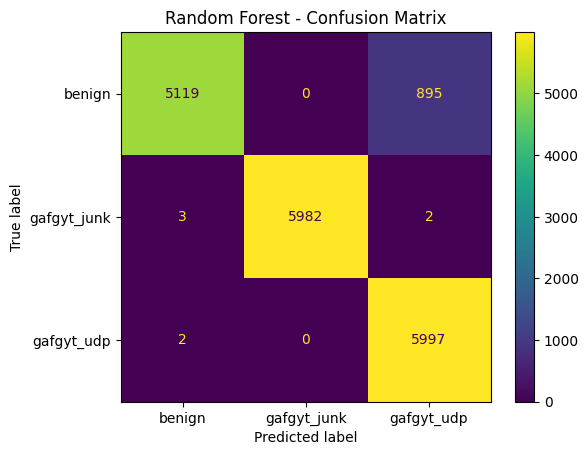

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Report
print("Random Forest Report")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, display_labels=le.classes_, cmap='viridis')
plt.title("Random Forest - Confusion Matrix")
plt.show()


## Train & Evaluate XGBoost

XGBoost Report
              precision    recall  f1-score   support

      benign       1.00      0.94      0.97      6014
 gafgyt_junk       1.00      1.00      1.00      5987
  gafgyt_udp       0.94      1.00      0.97      5999

    accuracy                           0.98     18000
   macro avg       0.98      0.98      0.98     18000
weighted avg       0.98      0.98      0.98     18000



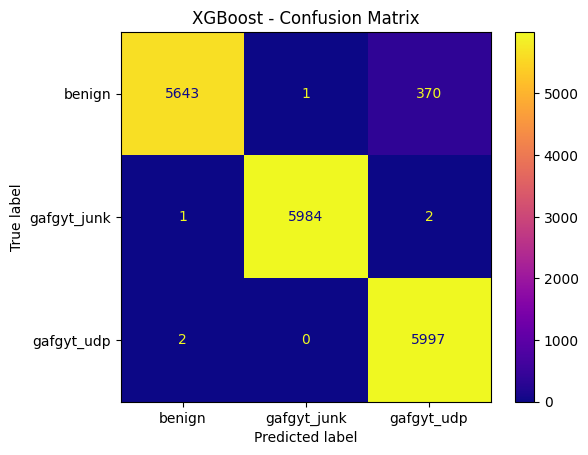

In [9]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Report")
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test, display_labels=le.classes_, cmap='plasma')
plt.title("XGBoost - Confusion Matrix")
plt.show()


## Train & Evaluate MLP Classifier

MLP Report
              precision    recall  f1-score   support

      benign       1.00      0.63      0.78      6014
 gafgyt_junk       1.00      1.00      1.00      5987
  gafgyt_udp       0.73      1.00      0.84      5999

    accuracy                           0.88     18000
   macro avg       0.91      0.88      0.87     18000
weighted avg       0.91      0.88      0.87     18000



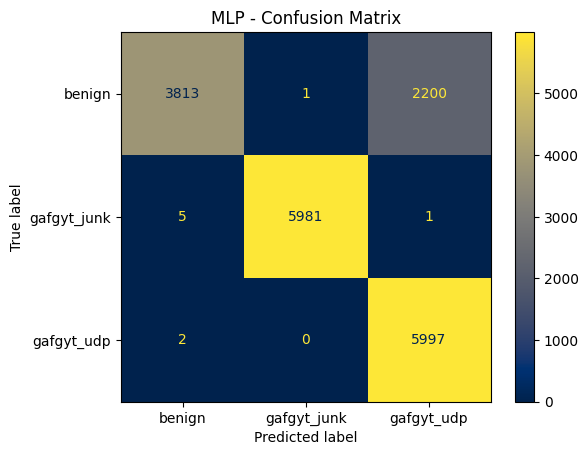

In [10]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=42, max_iter=300)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

print("MLP Report")
print(classification_report(y_test, y_pred_mlp, target_names=le.classes_))

ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test, display_labels=le.classes_, cmap='cividis')
plt.title("MLP - Confusion Matrix")
plt.show()

# Probability predictions for meta-model

In [11]:
proba_rf_train = rf.predict_proba(X_train)
proba_xgb_train = xgb.predict_proba(X_train)
proba_mlp_train = mlp.predict_proba(X_train)

proba_rf_test = rf.predict_proba(X_test)
proba_xgb_test = xgb.predict_proba(X_test)
proba_mlp_test = mlp.predict_proba(X_test)

# Combine stacked predictions

In [12]:
X_meta_train = np.hstack((proba_rf_train, proba_xgb_train, proba_mlp_train))
X_meta_test = np.hstack((proba_rf_test, proba_xgb_test, proba_mlp_test))

# Meta-Model (MLP using TensorFlow/Keras)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Encode target
y_train_cat = to_categorical(y_train, num_classes=len(le.classes_))

# Build meta-model
meta_model = Sequential()
meta_model.add(Dense(128, input_shape=(X_meta_train.shape[1],), activation='relu'))
meta_model.add(Dropout(0.5))
meta_model.add(Dense(64, activation='relu'))
meta_model.add(Dropout(0.3))
meta_model.add(Dense(len(le.classes_), activation='softmax'))

# Compile and train
meta_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
meta_model.fit(X_meta_train, y_train_cat, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


2025-04-22 10:55:53.844330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745319354.127064      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745319354.204695      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/50


2025-04-22 10:56:09.842918: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9579 - loss: 0.1922 - val_accuracy: 0.9805 - val_loss: 0.0773
Epoch 2/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9815 - loss: 0.0771 - val_accuracy: 0.9805 - val_loss: 0.0768
Epoch 3/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9801 - loss: 0.0812 - val_accuracy: 0.9805 - val_loss: 0.0807
Epoch 4/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9824 - loss: 0.0725 - val_accuracy: 0.9805 - val_loss: 0.0761
Epoch 5/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9821 - loss: 0.0727 - val_accuracy: 0.9805 - val_loss: 0.0755
Epoch 6/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9814 - loss: 0.0752 - val_accuracy: 0.9805 - val_loss: 0.0754
Epoch 7/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9820 - loss: 0.0733 - val_accuracy: 0.9805 - val_loss: 0.0756
Epoch 8/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9825 - loss: 0.0714 - val_accurac

## Meta-Model Evaluation

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Meta-Model Report
              precision    recall  f1-score   support

      benign       1.00      0.94      0.97      6014
 gafgyt_junk       1.00      1.00      1.00      5987
  gafgyt_udp       0.94      1.00      0.97      5999

    accuracy                           0.98     18000
   macro avg       0.98      0.98      0.98     18000
weighted avg       0.98      0.98      0.98     18000



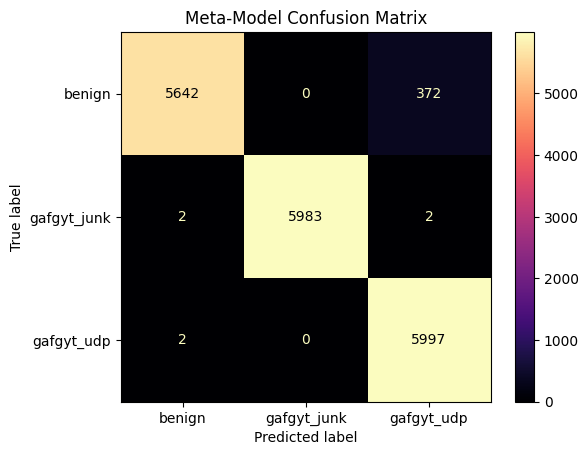

In [14]:
# Predict
y_pred_meta = np.argmax(meta_model.predict(X_meta_test), axis=1)

# Report
print("Meta-Model Report")
print(classification_report(y_test, y_pred_meta, target_names=le.classes_))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_meta, display_labels=le.classes_, cmap='magma')
plt.title("Meta-Model Confusion Matrix")
plt.show()


# Class Distribution (Before Sampling)

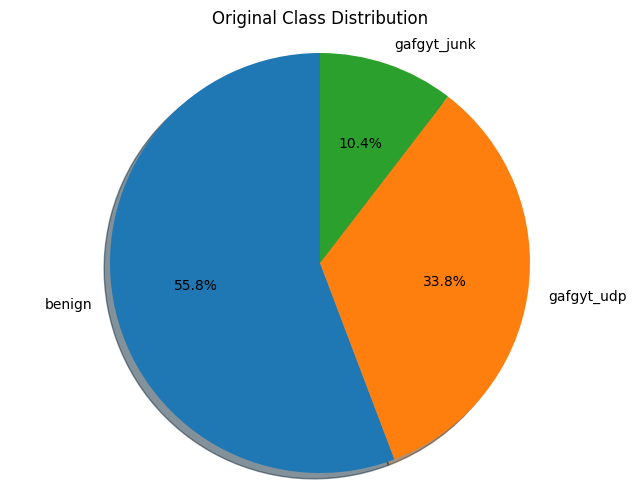

In [19]:
# Class distribution before sampling
class_counts = df['Attack_Class'].value_counts()

# Pie chart
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, shadow=True)
plt.title("Original Class Distribution")
plt.axis('equal')
plt.show()



#  Feature Trends

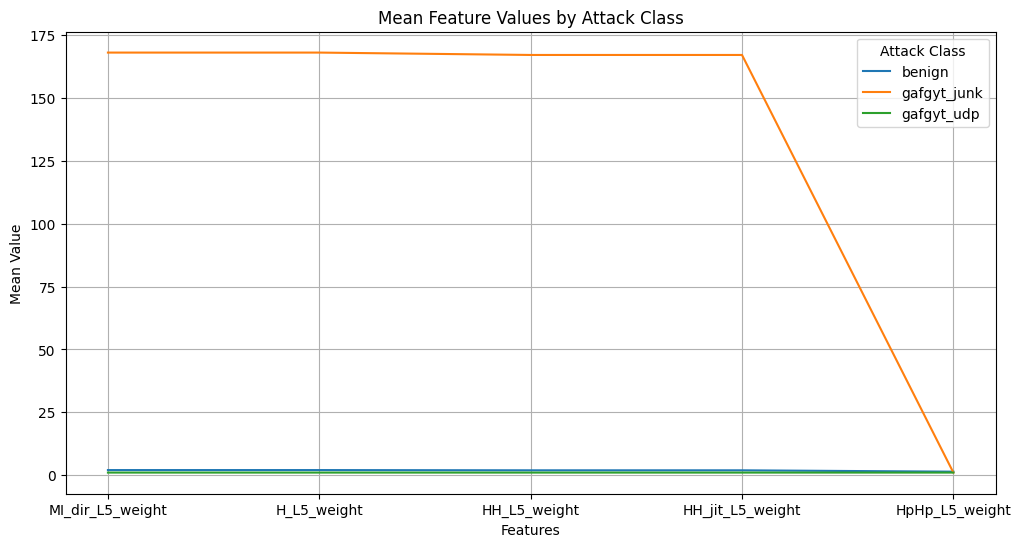

In [21]:
# Mean feature trend per class
mean_features = df_sampled.groupby('Attack_Class')[selected_features].mean().T

# Line plot
plt.figure(figsize=(12, 6))
for col in mean_features.columns:
    plt.plot(mean_features.index, mean_features[col], label=col)

plt.title("Mean Feature Values by Attack Class")
plt.xlabel("Features")
plt.ylabel("Mean Value")
plt.legend(title='Attack Class')
plt.grid(True)
plt.show()


# Feature Correlations

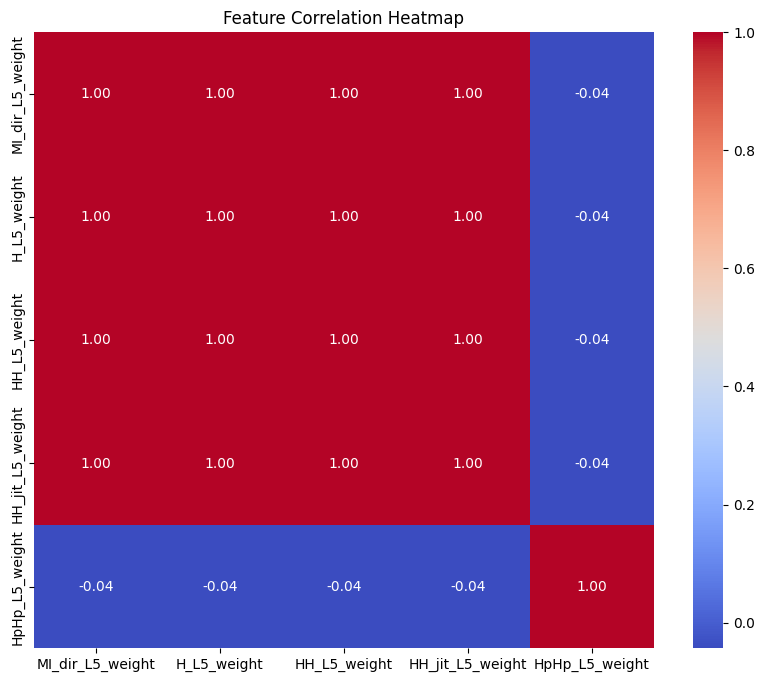

In [22]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
corr = df_sampled[selected_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


# Accuracy Comparison Between Models


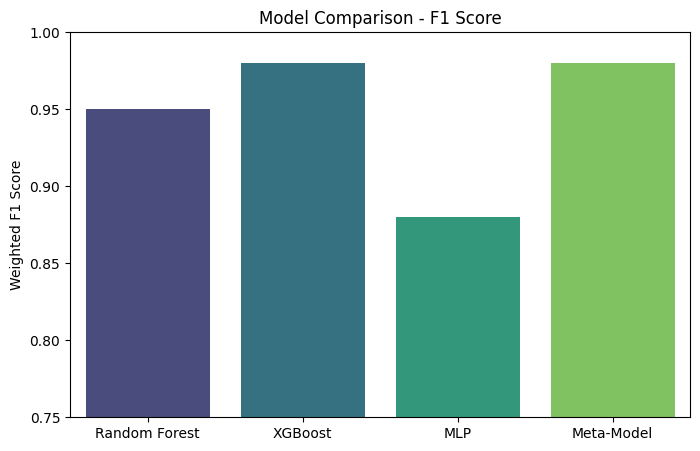

In [25]:
f1_scores = {
    "Random Forest": 0.95,
    "XGBoost": 0.98,
    "MLP": 0.88,
    "Meta-Model": 0.98
}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette='viridis')
plt.ylabel("Weighted F1 Score")
plt.title("Model Comparison - F1 Score")
plt.ylim(0.75, 1.0)
plt.show()
